Extract the details about the current resources in the Galaxy Training Material and some statistics

In [57]:
import base64
import matplotlib.pyplot as plt
import pandas as pd
import yaml

from github import Github
from pprint import pprint

1. Generate a Personal access tokens on GitHub (in Setting)
2. Add it to the `../config.yaml` after `github:`

In [58]:
with open("../config.yaml", "r") as stream:
    config = yaml.load(stream)

In [59]:
# connect to GitHub
g = Github(config["github"])
# retrieve the hub repository
repo = g.get_user("galaxyproject").get_repo("training-material")

In [60]:
# dates and corresponding commit
gitcommit_dates = {"22.06.17": "44164c9b", "15.05.17": "master"}

# Extract training content

In [61]:
def get_yaml_content(file_content):
    '''
    Extract the YAML content of the file from GitHub

    :param file_content: the encoded content of the file obtained with GitHub API

    :return: content in YAML of the file
    '''
    decoded_file_content = base64.b64decode(file_content)
    yaml_content = yaml.load(decoded_file_content)
    return yaml_content

In [62]:
def extract_training_content(ref):
    '''
    Extract the details about the current resources in the Galaxy Training Material

    :param ref: name of the commit/branch/tag

    :return: dictionary with information about the tutorials in each topic on ref
    '''
    trainings = {}
    for file in repo.get_dir_contents("metadata", ref):
        # get only topics
        if file.name == "contributors.yaml" or file.name == "instances.yaml":
            continue
        yaml_content = get_yaml_content(file.content)
        # get topic tutorial
        topic = yaml_content['title']
        trainings.setdefault(topic, {})
        for tuto in yaml_content['material']:
            tuto_name = tuto['title']
            # skip introduction and not stable tutorials
            if tuto['type'] == 'introduction':
                continue
            if 'enable' in tuto and tuto['enable'] == 'false':
                continue
            trainings[topic].setdefault(tuto_name, {})
            # collect information from the metadata.yaml file
            infos = ['hands_on', 'slides', 'galaxy_tour', 'workflows', 'zenodo_link']
            for info in infos:
                if info in tuto:
                    trainings[topic][tuto_name][info] = tuto[info]
                else:
                    trainings[topic][tuto_name][info] = False
            # collect the tool.yaml, data_library.yaml file
            tuto_path = "topics/%s/tutorials/%s" %(yaml_content['name'], tuto['name'])
            trainings[topic][tuto_name]['tools'] = False
            trainings[topic][tuto_name]['data_library'] = False
            for tuto_file in repo.get_dir_contents(tuto_path, ref):
                if tuto_file.name == 'data-library.yaml':
                    decoded_file_content = base64.b64decode(tuto_file.content)
                    if "Small file (to change)" in str(decoded_file_content) or "Small test files" in str(decoded_file_content):
                        continue
                    trainings[topic][tuto_name]['data_library'] = True
                elif tuto_file.name == 'tools.yaml':
                    decoded_file_content = base64.b64decode(tuto_file.content)
                    if "Where to put the tool" in str(decoded_file_content):
                        continue
                    trainings[topic][tuto_name]['tools'] = True
    return trainings

In [63]:
# extract training content
training_contents = {}
for d, git_com in gitcommit_dates.items():
    training_contents[d] = extract_training_content(git_com)

# Extract stats

In [64]:
def extract_training_stats(content, date):
    '''
    Extract the details about the current resources in the Galaxy Training Material

    :param content: dictionary with information about the tutorials in each topic on GitHub at the date given
    :param date: date corresponding

    :return: dictionary with some statistics about the training content on ref
    '''
    stats = pd.DataFrame({'topics': 0,
                          'tutorials': 0,
                          'hands_on': 0,
                          'slides': 0,
                          'galaxy_tour': 0,
                          'workflows': 0,
                          'zenodo_link': 0,
                          'tools': 0,
                          'data_library': 0},
                          index=[date])
    # extract stats
    hands_on_info = ["tools", "galaxy_tour", "workflows", "zenodo_link", "data_library"]
    no_hands_on_topic = ["Development in Galaxy", "Contributing to the Galaxy Training Material", "Train the trainers", "Galaxy Server administration"]
    for topic in content:
        stats.loc[date,'topics'] += 1
        for tuto in content[topic]:
            stats.loc[date,'tutorials'] += 1
            for info in list(stats.columns):
                if info in content[topic][tuto]:
                    if content[topic][tuto][info]:
                        if info in hands_on_info and topic in no_hands_on_topic:
                            continue
                        if content[topic][tuto][info] == "no":
                            continue
                        if content[topic][tuto][info] == "external":
                            continue
                        if content[topic][tuto][info] == "url to Zenodo with input data":
                            continue
                        stats.loc[date,info] += 1
                    elif info in hands_on_info and topic not in no_hands_on_topic:
                        print("%s - %s (%s)" % (topic, tuto, info))
    # reindex
    stats = stats[['topics','tutorials','hands_on','slides','tools','workflows','zenodo_link','data_library','galaxy_tour']]
    # rename columns
    stats = stats.rename(columns={"topics":"Topics",
                                  "tutorials":"Tutorials",
                                  "hands_on":"Hands-on",
                                  "slides":"Slide decks",
                                  "tools": "Tools",
                                  "workflows": "Worflows",
                                  "zenodo_link": "Data on Zenodo",
                                  "data_library": "Data for data libraries",
                                  "galaxy_tour": "Interactive tours"})
    return stats

In [65]:
# extract stats
training_stats = {}
for d, cont in training_contents.items():
    print(d)
    training_stats[d] = extract_training_stats(cont, d)
    print()

22.06.17
Assembly - Introduction to Genome Assembly (galaxy_tour)
Assembly - Introduction to Genome Assembly (workflows)
Assembly - De Bruijn Graph Assembly (galaxy_tour)
Assembly - De Bruijn Graph Assembly (workflows)
ChIP-Seq data analysis - Identification of the binding sites of the T-cell acute lymphocytic leukemia protein 1 (TAL1) (galaxy_tour)
ChIP-Seq data analysis - Identification of the binding sites of the T-cell acute lymphocytic leukemia protein 1 (TAL1) (workflows)
ChIP-Seq data analysis - ChIP-seq Galaxy Workshop (galaxy_tour)
ChIP-Seq data analysis - ChIP-seq Galaxy Workshop (workflows)
ChIP-Seq data analysis - ChIP-seq Galaxy Workshop (zenodo_link)
ChIP-Seq data analysis - ChIP-seq Galaxy Workshop (data_library)
Epigenetics - DNA Methylation data analysis (galaxy_tour)
Epigenetics - DNA Methylation data analysis (workflows)
Galaxy Introduction - Galaxy 101 (galaxy_tour)
Galaxy Introduction - Galaxy 101 (workflows)
Galaxy Introduction - Galaxy 101 (zenodo_link)
Galaxy In

Transcriptomics - Visualization of RNA-Seq results with CummeRbund (galaxy_tour)
Transcriptomics - Visualization of RNA-Seq results with CummeRbund (data_library)
Transcriptomics - Reference-based RNAseq data analysis (long) (galaxy_tour)
Transcriptomics - Reference-based RNAseq data analysis (long) (workflows)
Transcriptomics - Reference-based RNAseq data analysis (long) (zenodo_link)
Transcriptomics - Reference-based RNAseq data analysis (long) (tools)
Transcriptomics - Reference-based RNAseq data analysis (long) (data_library)
Variant Analysis - Exome sequencing data analysis (galaxy_tour)
Variant Analysis - Exome sequencing data analysis (workflows)
Variant Analysis - Mapping and molecular identification of phenotype-causing mutations (galaxy_tour)
Variant Analysis - Microbial Variant Calling (galaxy_tour)
Variant Analysis - Calling variants in non-diploid systems (galaxy_tour)
Variant Analysis - Calling variants in non-diploid systems (workflows)
Variant Analysis - Calling variant

In [66]:
# combine stats
all_stats = pd.concat(training_stats.values())
print(all_stats)

          Topics  Tutorials  Hands-on  Slide decks  Tools  Worflows  \
22.06.17      13         62        48           21     18         0   
15.05.17      14         81        63           31     30        26   

          Data on Zenodo  Data for data libraries  Interactive tours  
22.06.17              14                        9                  4  
15.05.17              32                       16                 16  


In [67]:
# export to csv
all_stats.to_csv("../data/repo_content_stats", index = True)

# Plot number of topics, tutorials, etc

In [68]:
content_stats = all_stats[["Topics", "Tutorials", "Hands-on", "Slide decks"]].transpose()

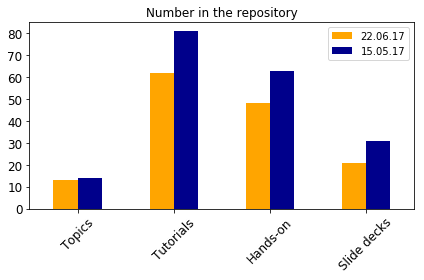

In [69]:
# plot barplot stats
ax = content_stats.plot(kind='bar', legend=True, fontsize=12, color=["orange","darkblue"], title="Number in the repository")
ax.set_xticklabels(content_stats.index, rotation=45)
plt.tight_layout()
plt.savefig("../images/repo_content_stat_plot.png", transparent=True)

In [70]:
# extract proportions
prop = pd.DataFrame({'Both hands-on and slide deck': 0,
                     'Only hands-on': 0,
                     'Only slide deck': 0},
                     index=all_stats.index)
prop['Both hands-on and slide deck'] = (all_stats['Hands-on'] + all_stats['Slide decks'] - all_stats['Tutorials'])/all_stats['Tutorials']
prop['Only hands-on'] = all_stats['Hands-on']/all_stats['Tutorials'] - prop['Both hands-on and slide deck']
prop['Only slide deck'] = all_stats['Slide decks']/all_stats['Tutorials'] - prop['Both hands-on and slide deck']
prop = prop * 100
print(prop)

          Both hands-on and slide deck  Only hands-on  Only slide deck
22.06.17                     11.290323      66.129032        22.580645
15.05.17                     16.049383      61.728395        22.222222


# Plot percentages of covered hands-on tutorials

In [71]:
tech_support_stats = all_stats[["Tools", "Worflows", "Data on Zenodo", "Data for data libraries", "Interactive tours"]].transpose()

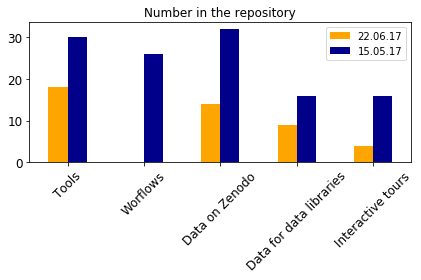

In [72]:
# plot barplot stats
ax = tech_support_stats.plot(kind='bar', legend=True, fontsize=12, color=["orange","darkblue"], title="Number in the repository")
ax.set_xticklabels(tech_support_stats.index, rotation=45)
plt.tight_layout()
plt.savefig("../images/tech_support_stat_plot.png", transparent=True)

In [73]:
# extract proportions
tech_support_perc = tech_support_stats
for d in list(all_stats.index):
    tech_support_perc[[d]] = 100 * tech_support_perc[[d]]/all_stats.loc[d,"Hands-on"]
print(tech_support_perc)

                          22.06.17   15.05.17
Tools                    37.500000  47.619048
Worflows                  0.000000  41.269841
Data on Zenodo           29.166667  50.793651
Data for data libraries  18.750000  25.396825
Interactive tours         8.333333  25.396825


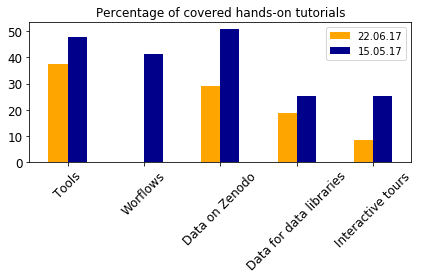

In [74]:
# plot percentage stats
ax = tech_support_perc.plot(kind='bar', legend = True, fontsize=12, color=["orange","darkblue"], title="Percentage of covered hands-on tutorials")
ax.set_xticklabels(tech_support_perc.index, rotation=45)
plt.tight_layout()
plt.savefig("../images/tech_support_prop_plot.png", transparent=True)